In [1]:
%matplotlib widget

# DEFAULTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("Deuteron/deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1
df_exp = pd.read_csv("./Deuteron/deuteron_exp_diffcross.csv")
df_exp_tot = pd.read_csv("./Deuteron/deuteron_exp_totcross.csv")

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

rachek_bins = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                          names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                 "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                 "T22", "T22stater", "T22syser"])


In [3]:
print(*OBSERVABLES)

CROSS CROSS2 P1 P2 PHIP WAVE T11D T20D T21D T22D T11D2 T20D2 T21D2 T22D2 AX AY AZ AX2 AY2 AZ2 POLNOUT(y) POLNOUT2(y) CROSSCAP CROSSCAP2 AYN1CAP AYN1CAP2 Energy


# Cross section

## Differential Cross Section

### Horizontal

In [5]:
obs = "CROSS2"
energy = 30
cutoff = 450


In [107]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
               (df_my.Energy == en) &
               # (df_my.FORCE.isin(FORCES[:-1])) &
               (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
    "CROSS2"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy, Lambda=650)


0.24737717255256778


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [121]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.Energy == 140) &
               (df_my.WAVE == "SIEGERT")]
df_piv = df_tmp.groupby("angle")["CROSS2"].agg(["min", "max"])
print("Max cutoff diff [%]")
((df_piv["max"]-df_piv["min"])/df_piv["max"]*100).max()

Max cutoff diff [%]


11.707317073170742

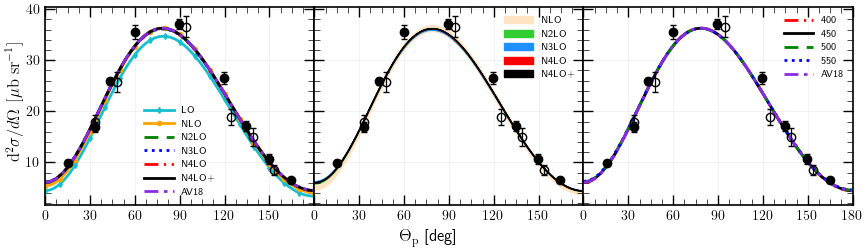

In [108]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(9, 2.8))
gs = fig.add_gridspec(ncols=3, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) &
                   (df_my.CUTOFF == cutoff) &
                   (df_my.Energy == energy) &
                   (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                             df_tmp[obs].values-df_trunc[force].values, label=force,
                             color=trunc_colors[force])
    # break
axes[1].legend()
for cut in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                   (df_my.CUTOFF == cut) &
                   (df_my.Energy == energy) &
                   (df_my.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cut], label=cut)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j, ax in enumerate(axes):
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
        ax.errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf",
            dpi=600, facecolor="white")
plt.show()


### Vertical

In [9]:
obs = "CROSS2"
energy = [30, 100, 140]
cutoff = 450

In [10]:
df_tmp = df_my[(df_my.CUTOFF == 450) &
               (df_my.Energy.isin(energy)) &
               # (df_my.FORCE.isin(FORCES[:-1])) &
               (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("angle", inplace=True)
df_trunc = {}
for en in energy:
    df_piv = df_tmp[df_tmp.Energy == en].pivot(index="angle", columns="FORCE")[
        "CROSS2"].reindex(FORCES, axis=1)
    df_trunc[en] = get_truncation(df_piv, en, Lambda=650)


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#### Order 

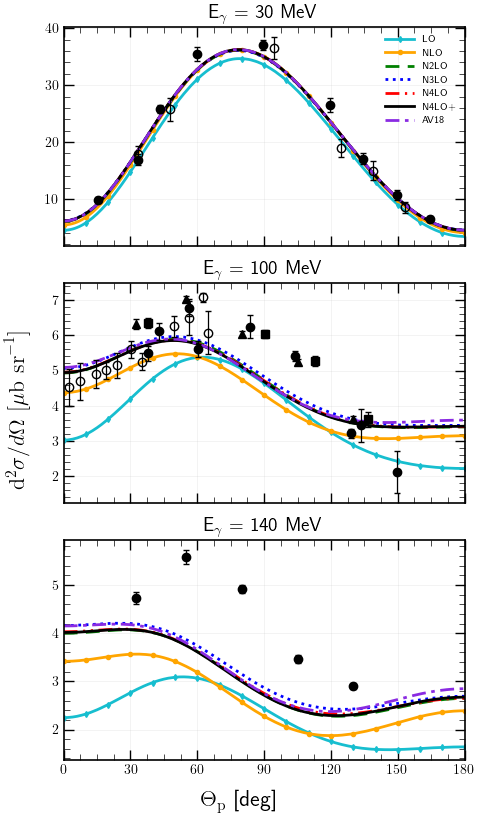

In [60]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    for force in FORCES:
        df_tmp = df_my[(df_my.FORCE == force) &
                    (df_my.CUTOFF == cutoff) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        ax[j].plot(df_tmp.angle, df_tmp[obs],
                    **line_styles[force], label=force)
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    ax[j].plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
fig.tight_layout()
plt.savefig(f"Figures_python/{obs}_order_vert.pdf",
            dpi=600, facecolor="white")
plt.show()


#### Cutoff

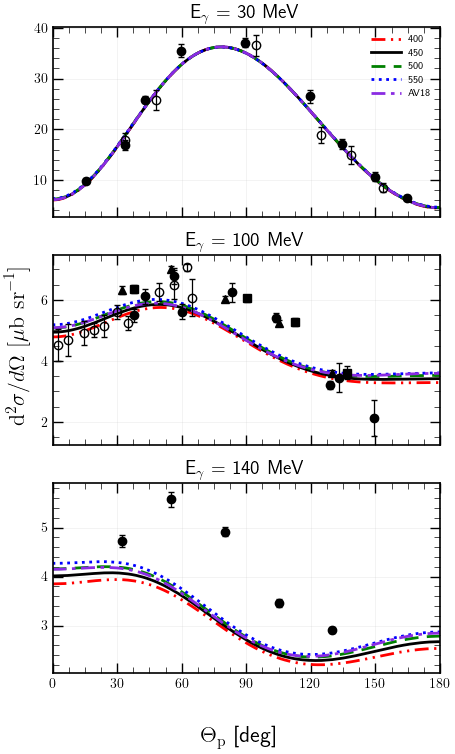

In [11]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    for cut in CUTOFF:
        df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == cut) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        ax[j].plot(df_tmp.angle, df_tmp[obs],
                    **ls_cutoff[cut], label=cut)
    df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == en)]
    ax[j].plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
# fig.tight_layout()
# plt.savefig(f"Figures_python/{obs}_cutoff_vert.pdf",
            # dpi=600, facecolor="white")
plt.show()


#### Truncation

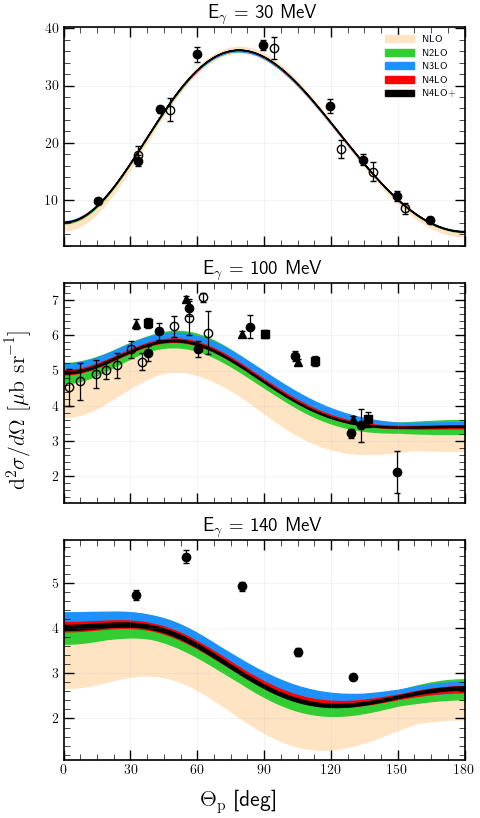

In [61]:
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3)
ax = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
fig.supylabel(ylabel, x=0.03, size=16)
for j, en in enumerate(energy):
    for force in FORCES:
        df_tmp = df_my[(df_my.FORCE == force) &
                    (df_my.CUTOFF == cutoff) &
                    (df_my.Energy == en) &
                    (df_my.WAVE == "SIEGERT")]
        if force != "LO":
            ax[j].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[en][force].values,
                                df_tmp[obs].values-df_trunc[en][force].values, label=force,
                                color=trunc_colors[force])

    for i, fname in enumerate(df_exp[df_exp.energy == en].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == en) & (df_exp.fname == fname)]
        ax[j].errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax[j].tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax[j].tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax[j].set_xticks(np.arange(0, 180+j-1, 30))
    ax[j].set_xlim([0, 180])
    ax[j].grid(alpha=0.2)
    ax[j].set_zorder(-1)
    ax[j].set_title(f"E$_\gamma$ = {en} MeV", size=14)
ax[0].legend(fontsize=7, handlelength=3)
fig.tight_layout()
plt.savefig(f"Figures_python/{obs}_truncation_vert.pdf",
            dpi=600, facecolor="white")
plt.show()

## Total Cross Section

In [3]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "SIEGERT")]


In [23]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "SIEGERT")]
df_piv = pd.pivot(df_tmp, index="THCM", columns="Energy")["CROSS2"]
CROSS_TOT = 2*np.pi*simpson(df_piv, x=df_piv.index.values, axis=0)
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               (df_my.CUTOFF == 450) &
               (df_my.WAVE == "1NC")]
df_piv = pd.pivot(df_tmp, index="THCM", columns="Energy")["CROSS2"]
CROSS_TOT_1nc = 2*np.pi*simpson(df_piv, x=df_piv.index.values, axis=0)


In [21]:
df_exp_tot.fillna(0, inplace=True)


Bernabei  ->  {'fmt': 'ok'}
Bosman  ->  {'fmt': 'ok', 'markerfacecolor': 'None', 'markeredgecolor': 'k'}
arends  ->  {'fmt': 'sk'}
Skopik  ->  {'fmt': '^k'}
Moreh  ->  {'fmt': 'Xk'}
Birenbaum  ->  {'fmt': 'dk'}


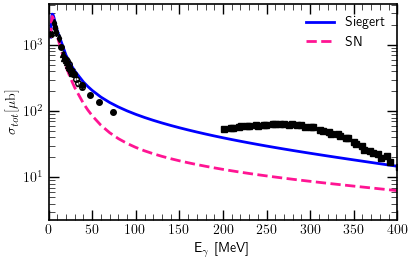

In [32]:
plt.figure(figsize=(4.5, 2.8))
# plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(my_energies, CROSS_TOT, label="Siegert", **line_styles["SIEGERT"])
plt.plot(my_energies, CROSS_TOT_1nc, label="SN", **line_styles["1NC"])
marker_common_tmp = {"markersize": 4, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
                 #  label=fname.split(".")[0].replace("data_arends1984", "arends"),
                 **exp_style[i], **marker_common_tmp)
    print(fname.split(".")[0].replace(
        "data_arends1984", "arends"), " -> ", exp_style[i])
# plt.legend(fontsize=7, handlelength=3)
plt.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
plt.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True)

plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()


plt.xlim([0, 400])
# plt.ylim([5,3000])
# plt.grid(which='both', alpha=0.5)
plt.savefig(f"Figures_python/TOTAL_CROSSSECTION.pdf",
            dpi=600, facecolor="white")
plt.show()


In [46]:
plt.close('all')


Bernabei  ->  {'fmt': 'ok'}
Bosman  ->  {'fmt': 'ok', 'markerfacecolor': 'None', 'markeredgecolor': 'k'}
arends  ->  {'fmt': 'sk'}
Skopik  ->  {'fmt': '^k'}
Moreh  ->  {'fmt': 'Xk'}
Birenbaum  ->  {'fmt': 'dk'}


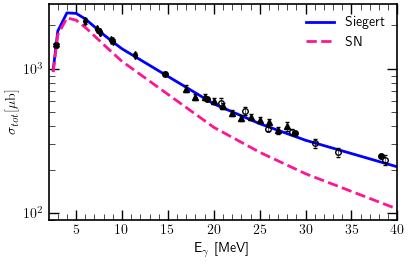

In [51]:
plt.figure(figsize=(4.5, 2.8))
# plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(my_energies, CROSS_TOT, label="Siegert", **line_styles["SIEGERT"])
plt.plot(my_energies, CROSS_TOT_1nc, label="SN", **line_styles["1NC"])
marker_common_tmp = {"markersize": 4, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
                 #  label=fname.split(".")[0].replace("data_arends1984", "arends"),
                 **exp_style[i], **marker_common_tmp)
    print(fname.split(".")[0].replace(
        "data_arends1984", "arends"), " -> ", exp_style[i])
# plt.legend(fontsize=7, handlelength=3)
plt.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
plt.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True)

plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()


plt.xlim([2, 40])
plt.ylim([90, 2800])
# plt.grid(which='both', alpha=0.5)
plt.savefig(f"Figures_python/TOTAL_CROSSSECTION_SMALL_REGION.pdf",
            dpi=600, facecolor="white")
plt.show()


## Truncation

In [13]:
df = pd.DataFrame(columns=FORCES)
for en in [30, 100, 140]:
    df_tmp = df_my[(df_my.CUTOFF == 450) &
                (df_my.Energy == en) &
                (df_my.WAVE == "SIEGERT")]

    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
        "CROSS2"].reindex(FORCES, axis=1)

    df.loc[en] = simpson(df_piv, 2*np.pi*df_piv.index.values, axis=0)
    df_trunc = get_truncation(df, en)
    

0.24737717255256778
0.45975130529305525
0.5427545059145633


In [14]:
df_trunc.set_index(df.index, inplace=True)

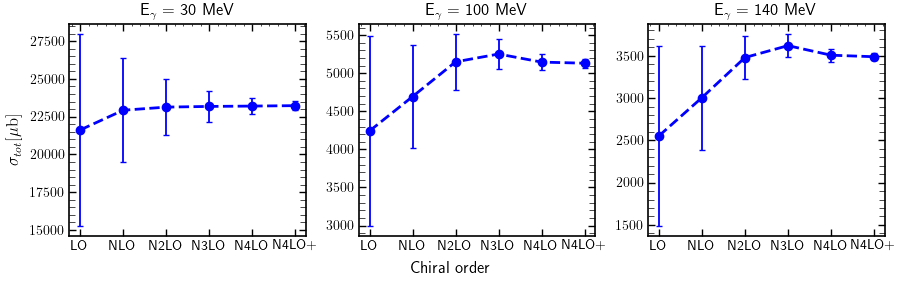

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("Chiral order", size=12)
fig.supylabel("$\sigma_{tot}[\mu \mathrm{b}]$", size=12)
for i, en in enumerate([30, 100, 140]):
    ax[i].errorbar(np.arange(6), df.loc[en], yerr=df_trunc.loc[en],
                   fmt="o--", color="blue", markersize=6, elinewidth=1.3, capsize=2.5)

    ax[i].tick_params(axis="y", which='minor', direction='in', length=4,
                      width=0.5, top=True, right=True)
    ax[i].tick_params(axis='x', which='minor', bottom=False)
    ax[i].tick_params(which='major', direction='in',
                      length=5, width=1, top=True, right=True)

    ax[i].set_title("E$_\gamma$ = {} MeV".format(en))
plt.setp(ax, xticks=np.arange(6), xticklabels=FORCES)

# plt.savefig(f"Figures_python/TOTAL_CROSSSECTION_Truncation.pdf",
            # dpi=600, facecolor="white")
plt.show()


## CUTOFF

In [16]:
df = pd.DataFrame(columns=CUTOFF)
for en in [30, 100, 140]:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.Energy == en) &
                (df_my.WAVE == "SIEGERT")]

    df_piv = df_tmp.pivot(index="angle", columns="CUTOFF")[
        "CROSS2"].reindex(CUTOFF, axis=1)

    df.loc[en] = simpson(df_piv, 2*np.pi*df_piv.index.values, axis=0)
    # df_trunc = get_truncation(df, en)
    

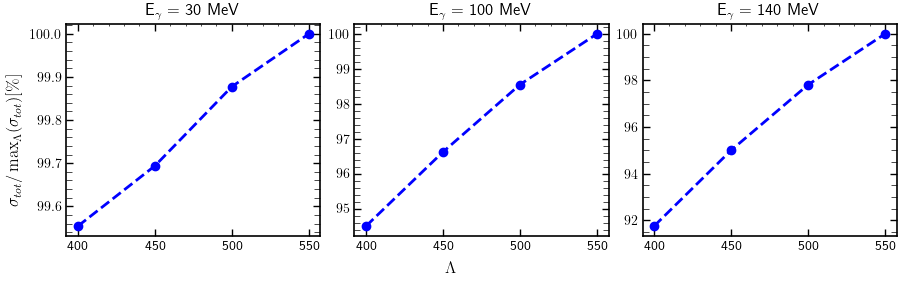

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("$\Lambda$", size=12)
# fig.supylabel("$\sigma_{tot}[\mu \mathrm{b}]$", size=12)
fig.supylabel("$\sigma_{tot} / \max_\Lambda(\sigma_{tot})[\%]$", size=12)
# fig.supylabel("$\sigma_{tot} / \sigma_{tot, \Lambda=550}[\%]$", size=12)
for i, en in enumerate([30, 100, 140]):
    ax[i].plot(np.arange(4), df.loc[en]/df.loc[en].max()*100, "--o",  color="blue", markersize=6)

    ax[i].tick_params(axis="y", which='minor', direction='in', length=4,
                      width=0.5, top=True, right=True)
    ax[i].tick_params(axis='x', which='minor', bottom=False)
    ax[i].tick_params(which='major', direction='in',
                      length=5, width=1, top=True, right=True)

    ax[i].set_title("E$_\gamma$ = {} MeV".format(en))
    # ax[i].set_xlim([-0.2, 3.2])
plt.setp(ax, xticks=np.arange(4), xticklabels=CUTOFF)

plt.savefig(f"Figures_python/TOTAL_CROSSSECTION_cutoff.pdf",
            dpi=600, facecolor="white")
plt.show()


# Tensor analyzing power

## Energy distribution

In [96]:
df_raczek_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T20_88.csv",
                               header=None, skiprows=2,
                               names=["raczek_X", "raczek_Y",
                                      "raczek_errX", "raczek_errY",
                                      "mishev_X", "mishev_Y",
                                      "mishev_errX", "mishev_errY"])
df_raczek_T20_88["raczek_err"] = df_raczek_T20_88["raczek_errY"] - \
    df_raczek_T20_88["raczek_Y"]
df_raczek_T20_88["mishev_err"] = df_raczek_T20_88["mishev_errY"] - \
    df_raczek_T20_88["mishev_Y"]

df_arenh_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T20.csv",
                              header=None, names=["energy", "T20"])

df_raczek_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T22_88.csv",
                               header=None, skiprows=2,
                               names=["raczek_X", "raczek_Y",
                                      "raczek_errX", "raczek_errY",
                                      "mishev_X", "mishev_Y",
                                      "mishev_errX", "mishev_errY"])
df_raczek_T22_88["raczek_err"] = df_raczek_T22_88["raczek_errY"] - \
    df_raczek_T22_88["raczek_Y"]
df_raczek_T22_88["mishev_err"] = df_raczek_T22_88["mishev_errY"] - \
    df_raczek_T22_88["mishev_Y"]

df_arenh_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T22.csv",
                              header=None, names=["energy", "T22"])


In [116]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
               # (df_my.CUTOFF == 450) &
               (df_my.angle == 88) &
               (df_my.WAVE == "SIEGERT")]
df_tmp = df_tmp.sort_values("Energy")


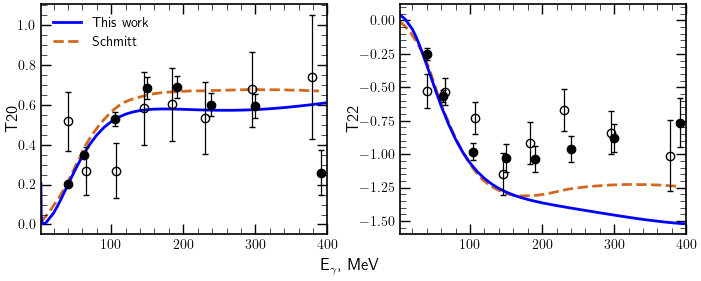

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.8), constrained_layout=True)
fig.supxlabel("E$_\gamma$, MeV", size=12)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 400].Energy,
#            df_tmp[df_tmp.CUTOFF == 400].T20D2,
#            label="N4LO+ 400", zorder=2, lw=2)

ax[0].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T20D2,
           label="This work", zorder=2, lw=2, **line_styles["SIEGERT"])

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 500].Energy,
#            df_tmp[df_tmp.CUTOFF == 500].T20D2,
#            label="N4LO+ 500", zorder=2, lw=2)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 550].Energy,
#            df_tmp[df_tmp.CUTOFF == 550].T20D2,
#            label="N4LO+ 550", zorder=2, lw=2)
ax[0].plot(df_arenh_T20_88.energy, df_arenh_T20_88.T20, label="Arenhovel",
           ls="dashed", zorder=1, lw=2, color="chocolate")
ax[0].errorbar(df_raczek_T20_88.raczek_X, df_raczek_T20_88.raczek_Y, yerr=df_raczek_T20_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[0].errorbar(df_raczek_T20_88.mishev_X, df_raczek_T20_88.mishev_Y, yerr=df_raczek_T20_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[0].legend(fontsize=6)
ax[0].tick_params(which='minor', direction='in', length=4,
                  width=0.5, top=True, right=True)
ax[0].tick_params(which='major', direction='in',
                  length=7, width=1, top=True, right=True)
ax[0].set_ylabel("T20", labelpad=-1, size=12)

ax[1].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T22D2,
           label="N4LO+",
           zorder=2, lw=2, **line_styles["SIEGERT"])
ax[1].plot(df_arenh_T22_88.energy, df_arenh_T22_88.T22,
           label="arenhovel", ls="dashed", zorder=1,
           lw=2, color="chocolate")
ax[1].errorbar(df_raczek_T22_88.raczek_X, df_raczek_T22_88.raczek_Y, yerr=df_raczek_T22_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[1].errorbar(df_raczek_T22_88.mishev_X, df_raczek_T22_88.mishev_Y, yerr=df_raczek_T22_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[1].legend(fontsize=6)
ax[1].tick_params(which='minor', direction='in', length=4,
                  width=0.5, top=True, right=True)
ax[1].tick_params(which='major', direction='in',
                  length=7, width=1, top=True, right=True)
ax[1].set_ylabel("T22", labelpad=-1, size=12)
ax[0].set_xlim([2.5, 400])
ax[1].set_xlim([2.5, 400])
# plt.ylabel(
ax[0].legend(["This work", "Schmitt"])
# fig.tight_layout()
plt.savefig(f"Figures_python/T20_T22_vs_en.pdf", dpi=600, facecolor="white")
plt.show()


## Angular distribution

In [91]:
rachek_angular = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                    "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                    "T22", "T22stater", "T22syser"])
rachek_angular["THerr"] = rachek_angular.THmean - rachek_angular.THmin


In [92]:
espans = list(map(lambda x: list(map(lambda x: int(float(x)), x.split())),
                  (rachek_angular.Emin.astype(str) + " " + rachek_angular.Emax.astype(str)).unique()))


In [9]:
print(espans)


[[25, 45], [45, 70], [70, 100], [100, 140], [140, 180], [180, 230], [230, 330], [330, 440]]


In [93]:
plt.close("all")


In [105]:
for espan in tqdm(espans):
    df_sieg = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy >= espan[0]) &
                    (df_my.Energy <= espan[1]) &
                    (df_my.angle >= 20) &
                    (df_my.angle <= 110) &
                    (df_my.WAVE == "SIEGERT")]
    df_1nc = df_my[(df_my.FORCE == "N4LO+") &
                   (df_my.CUTOFF == 450) &
                   (df_my.Energy >= espan[0]) &
                   (df_my.Energy <= espan[1]) &
                   (df_my.angle >= 20) &
                   (df_my.angle <= 110) &
                   (df_my.WAVE == "1NC")]
    df_exp = rachek_angular[(rachek_angular.Emin == espan[0]) & (
        rachek_angular.Emax == espan[1])]
    fig, ax = plt.subplots(1, 3, figsize=(9.5, 2.8), constrained_layout=True)
    fig.suptitle("E$_\gamma$ = {} - {} MeV".format(*espan))
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", size=12)

    for i, obs in enumerate(["T20", "T21", "T22"]):

        # Siegert
        df_gr = df_sieg.groupby(
            "angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr,
                           zorder=3, alpha=0.4, **line_styles["SIEGERT"])
        ax[i].plot(df_gr.angle, df_gr["mean"],
                   zorder=3, label="Siegert", **line_styles["SIEGERT"])
        # SN current
        df_gr_1nc = df_1nc.groupby(
            "angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr_1nc,
                           zorder=2, alpha=0.3,
                           **line_styles["1NC"])
        ax[i].plot(df_gr_1nc.angle, df_gr_1nc["mean"],
                   zorder=2, label="SN", **line_styles["1NC"])
        # experiment
        ax[i].errorbar(x="THmean", y=obs, yerr=obs + "stater", data=df_exp,
                       zorder=4, label=None, **exp_style[0], **marker_common)

        # style
        ax[i].axhline(c="k", zorder=1, lw=1.2)
        ax[i].set_ylabel(obs, labelpad=-1, size=12)
        ax[i].set_xlim([20, 110])
        ax[i].tick_params(which='minor', direction='in',
                          length=4, width=0.5, top=True, right=True)
        ax[i].tick_params(which='major', direction='in',
                          length=7, width=1, top=True, right=True)
    ax[1].legend(fontsize=8)
    plt.savefig("Figures_python/Tensor_analyzing_power_angular_E{}-{}.pdf".format(*
                                                                                  espan), dpi=600, facecolor="white")
    # plt.show()
    plt.close()
    # break


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


## Integrated

In [108]:
from copy import deepcopy

rachek_integr = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_egamma.txt",
                            delim_whitespace=True,
                            names=['E-gamma_start', 'E-gamma_end', 'E-gamma_mean', 'Theta-p_start',
                                   'Theta-p_end', 'Theta-p_mean', 'T20_value', 'T20_stat_err',
                                   'T20_sys_err', 'T21_value', 'T21_stat_err', 'T21_sys_err',
                                   'T22_value', 'T22_stat_err', 'T22_sys_err'])
rachek_integr = rachek_integr[rachek_integr["E-gamma_start"] < 400]
Eerr = np.array(list(zip(rachek_integr["E-gamma_mean"]-rachek_integr["E-gamma_start"],
                         rachek_integr["E-gamma_end"]-rachek_integr["E-gamma_mean"])))


In [111]:
# angles = (24, 48)
angles = (70, 102)
data = {
    "SIEGERT": {
        "min": [],
        "max": [],
        "mean": []
    },
    "1NC": {
        "min": [],
        "max": [],
        "mean": []
    }
}
data_all = {}
for i in range(3):
    obs = f"T2{i}"
    data_all[obs] = deepcopy(data)

    df_local = df_my[(df_my.FORCE == "N4LO+") &
                     (df_my.CUTOFF == 450) &
                     (df_my.angle >= angles[0]) &
                     (df_my.angle <= angles[1])]
    for energy in tqdm(my_energies, desc=obs):
        for wave in ["1NC", "SIEGERT"]:
            df_tmp = df_local[
                (df_local.Energy == energy) &
                (df_local.WAVE == wave)
            ]
            x = df_tmp.THCM.values
            y = df_tmp[obs + "D2"].values
            mean = np.mean(y)
            # std = np.std(y)
            data_all[obs][wave]["mean"].append(mean)
            data_all[obs][wave]["min"].append(np.min(y))
            data_all[obs][wave]["max"].append(np.max(y))


T22: 100%|██████████| 50/50 [00:00<00:00, 614.27it/s]


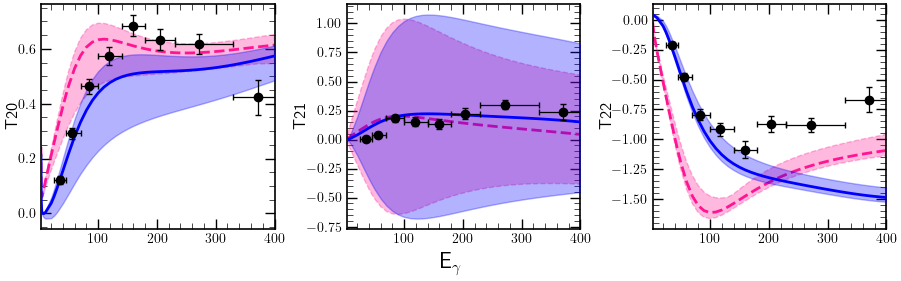

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(9, 2.8), constrained_layout=True)
fig.supxlabel("E$_\gamma$", size=16)
for i in range(3):
    obs = f"T2{i}"
    for num, current_type in enumerate(["1NC", "SIEGERT"]):
        ax[i].fill_between(my_energies, data_all[obs][current_type]["min"],
                           data_all[obs][current_type]["max"],
                           alpha=0.3, zorder=2+num,
                           **line_styles[current_type])
        ax[i].plot(my_energies, data_all[obs][current_type]["mean"],
                   zorder=2+num, **line_styles[current_type])

    ax[i].errorbar(x="E-gamma_mean", y=f"{obs}_value", yerr=f"{obs}_stat_err",
                   xerr=Eerr[np.where((rachek_integr["Theta-p_start"] >= angles[0]) &
                                      (rachek_integr["Theta-p_end"] <= angles[1]))].T,
                   data=rachek_integr[(rachek_integr["Theta-p_start"] >= angles[0]) &
                                      (rachek_integr["Theta-p_end"] <= angles[1])],
                   zorder=4, **exp_style[0], **marker_common)
    ax[i].tick_params(which='minor', direction='in',
                      length=4, width=0.5, top=True, right=True)
    ax[i].tick_params(which='major', direction='in',
                      length=7, width=1, top=True, right=True)
#     ax[i].grid(zorder=1)
#     ax[i].axhline(c="k", zorder=1, lw=1.2)
    ax[i].set_ylabel(obs, size=12, labelpad=-1)
    ax[i].set_xlim([2.5, 400])
# fig.tight_layout()
plt.savefig("Figures_python/TensorPower_Th{}-{}.pdf".format(*
                                                            angles), dpi=600, facecolor="white")
plt.show()


### Test

In [235]:
dfr_tmp = rachek_integr[(rachek_integr["Theta-p_start"] >= angles[0]) &
                        (rachek_integr["Theta-p_end"] <= angles[1])]


## cross-like

In [6]:
def make_fig(obs, energy, cutoff, df, exp=None, wave="SIEGERT", ylabel=None, save=True):
    df_tmp = df[(df.CUTOFF == cutoff) &
               (df.Energy == energy) &
               (df.WAVE == wave)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, energy)

    fig = plt.figure(figsize=(5, 8.4))
    gs = fig.add_gridspec(nrows=3, hspace=0)
    axes = gs.subplots(sharex=True)
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
    if not ylabel:
        ylabel = obs
    fig.supylabel(ylabel, x=0.03, size=16)
    for force in FORCES:
        df_tmp = df[(df.FORCE == force) &
                    (df.CUTOFF == cutoff) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[0].plot(df_tmp.angle, df_tmp[obs],
                    **line_styles[force], label=force)
        if force != "LO":
            axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                                df_tmp[obs].values-df_trunc[force].values, label=force,
                                color=trunc_colors[force])
        # break
    for cut in CUTOFF:
        df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.CUTOFF == cut) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[2].plot(df_tmp.angle, df_tmp[obs],
                    **ls_cutoff[cut], label=cut)
    df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
    for j, ax in enumerate(axes):
        if j != 1:
            ax.plot(df_av18.angle, df_av18[obs],
                    **line_styles["AV18"], label="AV18")
        # style
        ax.legend(fontsize=9, handlelength=3, loc="best")
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        ax.set_xticks(np.arange(0, 180+j-1, 30))
        ax.set_xlim([0, 180])
        ax.grid(alpha=0.2)
        ax.set_zorder(-1)
    fig.tight_layout()
    if save:
        plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf",
                    dpi=600, facecolor="white")
    return ax, fig

In [6]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


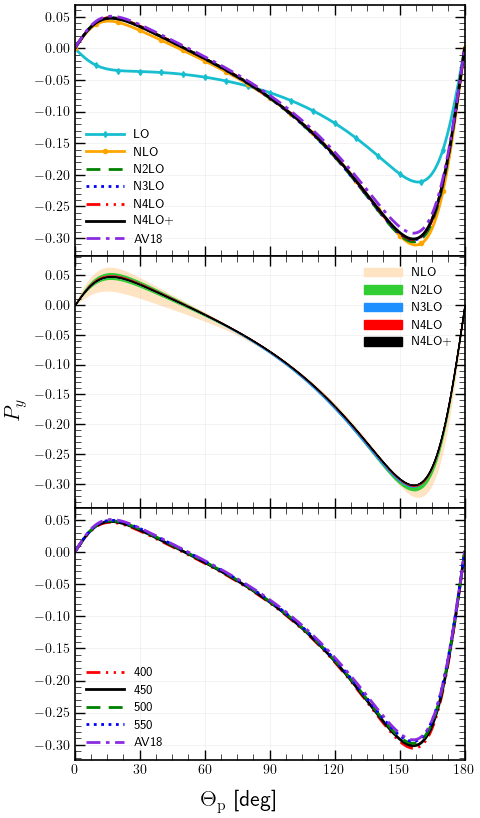

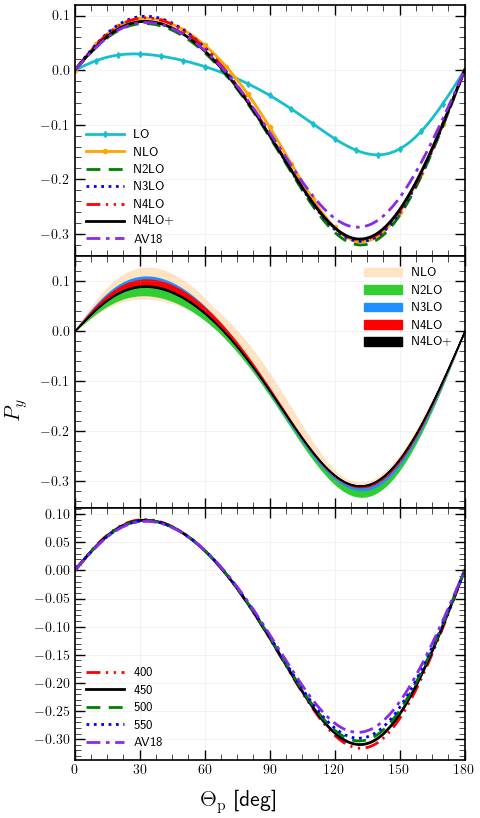

In [7]:
for en in [30, 100]:
#     ax, fig = make_fig("AYN1CAP2", en, 450, df_my, save=True)
    ax, fig = make_fig("POLNOUT2(y)", en, 450, df_my, save=True, ylabel="$P_y$")


# Assymetry

In [87]:
print(OBSERVABLES)


['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


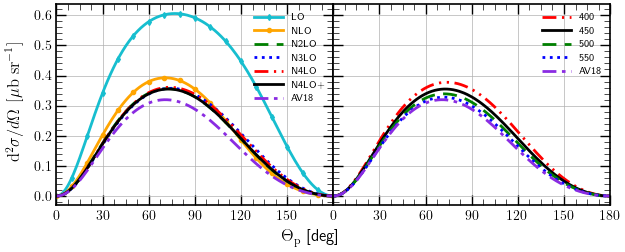

In [4]:
obs = "AX2"
ylabel = "$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"
energy = 100

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(6.5, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) & (df_my.CUTOFF == 450) & (
        df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label=force)
for cutoff in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") & (df_my.CUTOFF == cutoff)
                   & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[1].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cutoff], label=cutoff)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j, ax in enumerate(axes):
    ax.plot(df_av18.angle, df_av18[obs],
            **line_styles["AV18"], label="AV18")
    # for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
    #     df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
    #     ax.errorbar(df_tmp.angle, df_tmp.CROSS,
    #                 yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    ax.grid()
fig.tight_layout()
# plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf", dpi=600, facecolor="white")
plt.show()
